In [1]:
!pip install --upgrade scikit-learn  

Defaulting to user installation because normal site-packages is not writeable


In [2]:
## if the requirements were not already satisfied you have to restart the kernel

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [4]:
conn = sqlite3.connect('../data/raw/td_V2.db')
git_commits = pd.read_sql_query("SELECT * FROM GIT_COMMITS",conn)
szz_fault_inducing_commits = pd.read_sql_query("SELECT * FROM SZZ_FAULT_INDUCING_COMMITS",conn)
refactoring_miner = pd.read_sql_query("SELECT * FROM REFACTORING_MINER",conn)
refactoring_miner = refactoring_miner[refactoring_miner["COMMIT_HASH"].isin(git_commits["COMMIT_HASH"])]
git_commits_changes = pd.read_sql_query("SELECT * FROM GIT_COMMITS_CHANGES", conn)
git_commits_changes = git_commits_changes[git_commits_changes["COMMIT_HASH"].isin(refactoring_miner["COMMIT_HASH"])]

In [5]:
refactor_commits = pd.read_csv("../data/processed/refactor_commits.csv", encoding='utf8', engine='python')

In [6]:
refactor_commits.head()

,COMMIT_HASH,REFACTORING_TYPE,COMMIT_DAY,LINES_ADDED,LINES_REMOVED,LINES_ADDED_LAST_COMMITS,LINES_REMOVED_LAST_COMMITS,LABEL
0,23df647cf944b6c33ab23f0433305c153e247839,Move Class,6421,19,14,957,42,0
1,0a2576bbf0225626c1e2af1ade360ac15675fb65,Move Class,6420,21,16,939,32,0
2,a0dd0a5298bb8447511759a869956ac448220db5,Move Source Folder,6170,40,3,1101,29,0
3,1661dbe6278577d344ebe1592308671a7c27bef2,Move Source Folder,6169,108,1,996,31,0
4,49d15d8f0c66f1b41c1aab24430f129388826e89,Move Source Folder,5625,748,22,294,9,0


In [7]:
def plot_monthly_commits(git_commits, project_id):
    data = git_commits[git_commits.PROJECT_ID == project_id][['COMMITTER_DATE']]
    plt.figure(figsize=(20,10))
    plt.hist(pd.to_datetime(data['COMMITTER_DATE']).dt.to_period('M').astype(str), bins=len(pd.to_datetime(data['COMMITTER_DATE']).dt.to_period('M').astype(str).unique()),
            color=('cornflowerblue'),edgecolor = 'silver')
    plt.xticks(pd.to_datetime(data['COMMITTER_DATE']).dt.to_period('M').astype(str).unique()[::5], rotation=70)
#     plt.hist(pd.to_datetime(data['COMMITTER_DATE']).dt.date.astype(str), bins=len(pd.to_datetime(data['COMMITTER_DATE']).dt.date.astype(str).unique()),
#             color=('cornflowerblue'),edgecolor = 'silver')
#     plt.xticks(pd.to_datetime(data['COMMITTER_DATE']).dt.date.astype(str).unique()[::5], rotation=70)
    plt.title('Monthly commits of: ' + project_id, size=18)
    plt.ylabel('Number of commits', size=14)
    plt.xlabel('Month', size=14)
    plt.show()


/home/lena/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


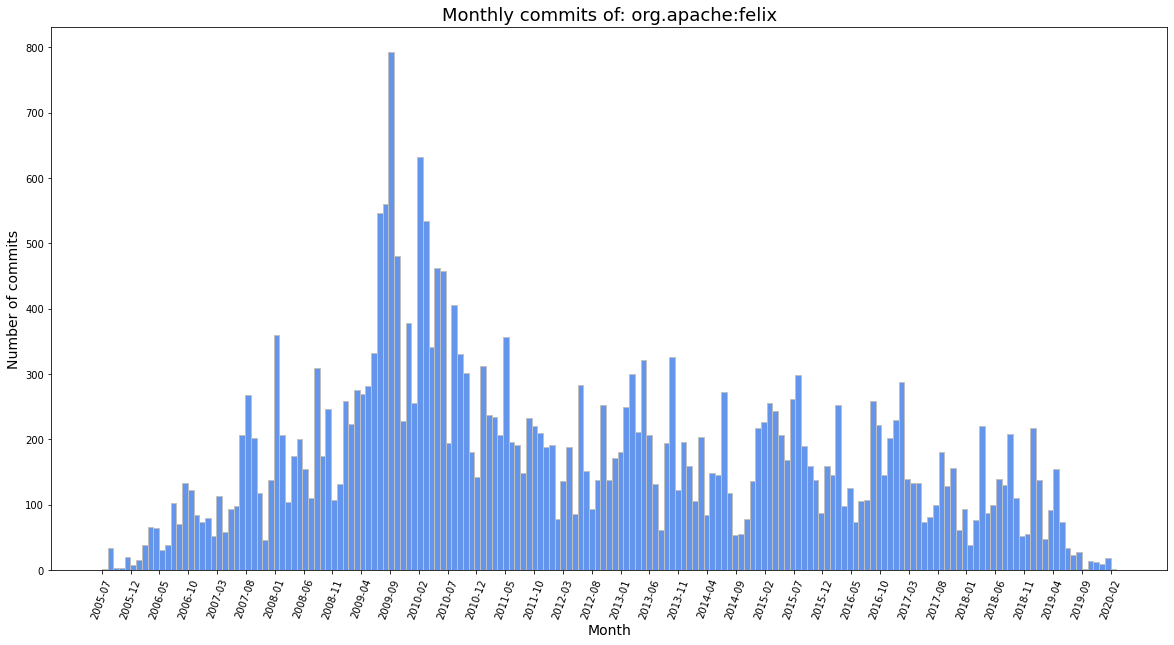

In [8]:
plot_monthly_commits(git_commits, 'org.apache:felix')

In [9]:
def compute_metrics(y_test, predicts):
    print('Metrics for one partition: \n')
    print('confusion matrix:\n', confusion_matrix(y_test, predicts), '\n')
    print('accuracy:', accuracy_score(y_test, predicts))
    print('precision:', precision_score(y_test, predicts))
    print('recall:', recall_score(y_test, predicts))
    print('f1:', f1_score(y_test, predicts))
    pass

###  SUPPORT VECTOR MACHINE

In [10]:
y = refactor_commits["LABEL"]
X = refactor_commits.drop(columns = ["COMMIT_HASH","LABEL"])
X["REFACTORING_TYPE"] = X["REFACTORING_TYPE"].astype("category").cat.codes

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
svm_model = svm.SVC(kernel = 'rbf')
svm_model.fit(X_train, y_train)
predicts = svm_model.predict(X_test)
compute_metrics(y_test, predicts)

Metrics for one partition: 

confusion matrix:
 [[2524    6]
 [ 977   20]] 

accuracy: 0.7212928834703715
precision: 0.7692307692307693
recall: 0.020060180541624874
f1: 0.039100684261974585


In [12]:
print('Metrics averaged over 10 different partitions:\n')
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)
accuracies = []
precisions = []
recalls = []
f1s = []

for train_index, test_index in kf.split(X):
    svm_model = svm.SVC(kernel = 'rbf')
    svm_model.fit(X.iloc[train_index], y[train_index])
    pred = svm_model.predict(X.iloc[test_index])

    accuracies.append(accuracy_score(y[test_index], pred))
    precisions.append(precision_score(y[test_index], pred))
    recalls.append(recall_score(y[test_index], pred))
    f1s.append(f1_score(y[test_index], pred)) 

print('mean accuracy:', round(np.mean(accuracies),3))
print('mean precision:', round(np.mean(precisions),3))
print('mean recall:', round(np.mean(recalls),3))
print('mean f1:', round(np.mean(f1s),3))

Metrics averaged over 10 different partitions:

mean accuracy: 0.72
mean precision: 0.785
mean recall: 0.015
mean f1: 0.03


### GLM BINOMIAL

In [13]:
y_train = pd.Series(y_train).replace(1,0.95).replace(0,0.05)
y_train = np.asarray(y_train).astype(float)
model = sm.GLM(y_train,X_train, family = sm.families.Binomial())
res = model.fit()
res = res.predict(X_test)

In [14]:
compute_metrics(y_test, res > 0.5)

Metrics for one partition: 

confusion matrix:
 [[2520   10]
 [ 994    3]] 

accuracy: 0.7153388148568188
precision: 0.23076923076923078
recall: 0.003009027081243731
f1: 0.005940594059405941


In [15]:
print('Metrics averaged over 10 different partitions:\n')
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)
accuracies = []
precisions = []
recalls = []
f1s = []

for train_index, test_index in kf.split(X):
    model = sm.GLM(y[train_index],X.iloc[train_index], family = sm.families.Binomial())
    res = model.fit()
    pred = res.predict(X.iloc[test_index])
    
    accuracies.append(accuracy_score(y[test_index], pred > 0.5))
    precisions.append(precision_score(y[test_index], pred > 0.5))
    recalls.append(recall_score(y[test_index], pred > 0.5))
    f1s.append(f1_score(y[test_index], pred > 0.5)) 
    
print('mean accuracy:', round(np.mean(accuracies),3))
print('mean precision:', round(np.mean(precisions),3))
print('mean recall:', round(np.mean(recalls),3))
print('mean f1:', round(np.mean(f1s),3))

Metrics averaged over 10 different partitions:

mean accuracy: 0.715
mean precision: 0.313
mean recall: 0.004
mean f1: 0.008


### RANDOM FOREST

In [16]:
values = np.array(refactor_commits.REFACTORING_TYPE)

# first apply label encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

# now we can apply one hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [18]:
a = pd.get_dummies(pd.cut(refactor_commits['COMMIT_DAY'], bins=[0,694,1738,3409,6450],labels=['COMMIT_DAY[0,694]','COMMIT_DAY[694,1738]','COMMIT_DAY[1738,3409]','COMMIT_DAY[3409,6450]']))
b = pd.get_dummies(pd.cut(refactor_commits['LINES_ADDED'], bins=[0,52,181,542,119045],labels=['LINES_ADDED[0,52]','LINES_ADDED[52,181]','LINES_ADDED[181,542]','LINES_ADDED[542,119045]']))
c = pd.get_dummies(pd.cut(refactor_commits['LINES_REMOVED'], bins=[0,22,92,298,119047],labels=['LINES_REMOVED[0,22]','LINES_REMOVED[22,92]','LINES_REMOVED[92,298]','LINES_REMOVED[298,119047]']))
d = pd.get_dummies(pd.cut(refactor_commits['LINES_ADDED_LAST_COMMITS'], bins=[0,541,1080,2246,178258],labels=['LINES_ADDED_LAST_COMMITS_1','LINES_ADDED_LAST_COMMITS_2','LINES_ADDED_LAST_COMMITS_3','LINES_ADDED_LAST_COMMITS_4']))
e = pd.get_dummies(pd.cut(refactor_commits['LINES_REMOVED_LAST_COMMITS'], bins=[0,265,569,1219,179351],labels=['LINES_REMOVED_LAST_COMMITS_1','LINES_REMOVED_LAST_COMMITS_2','LINES_REMOVED_LAST_COMMITS_3','LINES_REMOVED_LAST_COMMITS_4']))
f = pd.get_dummies(refactor_commits.REFACTORING_TYPE)
data = pd.concat([a, b, c, d, e, f, refactor_commits['LABEL']], axis=1)


In [19]:
data.head()

,"COMMIT_DAY[0,694]","COMMIT_DAY[694,1738]","COMMIT_DAY[1738,3409]","COMMIT_DAY[3409,6450]","LINES_ADDED[0,52]","LINES_ADDED[52,181]","LINES_ADDED[181,542]","LINES_ADDED[542,119045]","LINES_REMOVED[0,22]","LINES_REMOVED[22,92]",...,Push Down Method,Rename Attribute,Rename Class,Rename Method,Rename Package,Rename Parameter,Rename Variable,Replace Attribute,Replace Variable With Attribute,LABEL
0,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X = data.drop(columns='LABEL')
y = data['LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=100, class_weight={0:0.3, 1:0.7})
clf.fit(X, y)
pred = clf.predict(X_test)

In [21]:
print('Metrics for one partition: \n')
print('confusion matrix:\n', confusion_matrix(y_test, pred), '\n')

print('accuracy:', accuracy_score(y_test, pred))
print('precision:', precision_score(y_test, pred))
print('recall:', recall_score(y_test, pred))
print('f1:', f1_score(y_test, pred))

Metrics for one partition: 

confusion matrix:
 [[1963  567]
 [ 559  438]] 

accuracy: 0.6807485114828467
precision: 0.43582089552238806
recall: 0.43931795386158473
f1: 0.43756243756243757


In [22]:
print('Metrics averaged over 10 different partitions:\n')
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)
accuracies = []
precisions = []
recalls = []
f1s = []

for train_index, test_index in kf.split(X):
    clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=100, class_weight={0:0.3, 1:0.7})
    clf.fit(X.iloc[train_index], y[train_index])
    pred = clf.predict(X.iloc[test_index])
    
    accuracies.append(accuracy_score(y[test_index], pred))
    precisions.append(precision_score(y[test_index], pred))
    recalls.append(recall_score(y[test_index], pred))
    f1s.append(f1_score(y[test_index], pred)) 
    
print('mean accuracy:', round(np.mean(accuracies),3))
print('mean precision:', round(np.mean(precisions),3))
print('mean recall:', round(np.mean(recalls),3))
print('mean f1:', round(np.mean(f1s),3))

Metrics averaged over 10 different partitions:

mean accuracy: 0.679
mean precision: 0.436
mean recall: 0.455
mean f1: 0.444
